# **Instalación de librerías**

# **Librerías usadas**

In [1]:
# !pip install mxnet gluonnlp d2l
!pip install openpyxl




!pip d2l

from d2l import mxnet as d2l

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
import gluonnlp as nlp
import mxnet as mx
import re
import numpy as np
import math
import pandas as pd
import random

from mxnet import gluon
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, roc_curve, auc
from d2l import mxnet as d2l
from IPython.display import display

# **Variables globales**
## **Parámetros a cambiar:**

In [3]:
def try_all_gpus():
    devices = [d2l.gpu(i) for i in range(d2l.num_gpus())]
    return devices if devices else [d2l.cpu()]
# ctx = try_all_gpus()
ctx = [mx.cpu(0), mx.cpu(1), mx.cpu(2), mx.cpu(3), mx.cpu(4), mx.cpu(5), mx.cpu(6), mx.cpu(7)]
print(ctx)

[cpu(0), cpu(1), cpu(2), cpu(3), cpu(4), cpu(5), cpu(6), cpu(7)]


- Las cuatro primeras variables corresponden a las direcciones de los archivos OCR y REF de entrenamiento y de testeo
- **max_sequence_length:** número de palabras por oración
- **max_len:** número de tokens, incluidas las etiquetas de relleno
- **batch_size:** tamaño del batch
- **lr:** learning rate
- **num_epochs:** épocas para entrenamiento
- **num_muestras_entrenamiento:** número de muestras para entrenamiento (máximo 237097)
- **num_muestras_evaluacion:** número de muestras para evaluación (máximo 12462)

In [4]:
archivo_OCR_train = 'TesisModelo1/0_Corpus/3_Entrenamiento/corpus_OCR_procesada.txt'
archivo_REF_train = 'TesisModelo1/0_Corpus/3_Entrenamiento/corpus_REF_procesada.txt'
archivo_OCR_test = 'TesisModelo1/0_Corpus/3_Testeo/corpus_OCR_procesada.txt'
archivo_REF_test = 'TesisModelo1/0_Corpus/3_Testeo/corpus_REF_procesada.txt'

max_words_len = 20
max_len = 25
batch_size = 128
num_classes = 2
lr = 0.00001
num_epochs = 10
num_muestras_entrenamiento = 10000
num_muestras_evaluacion = 3000

model, vocab = nlp.model.get_model('bert_12_768_12', dataset_name='book_corpus_wiki_en_uncased', ctx=ctx, use_classifier=False, use_decoder=False)
tokenizer = nlp.data.BERTTokenizer(vocab, lower=True)
transform = nlp.data.BERTSentenceTransform(tokenizer, max_len, pair=False, pad=False)

log_interval = 1

# **Función para cargar los archivos**

In [5]:
def cargar_corpus(archivo_OCR, archivo_REF):
    corpus_OCR, corpus_REF = [], []

    with open(archivo_OCR, 'r', encoding='utf-8') as f:
        for linea in f:
            corpus_OCR.append(linea.strip())

    with open(archivo_REF, 'r', encoding='utf-8') as f:
        for linea in f:
            corpus_REF.append(linea.strip())

    return corpus_OCR, corpus_REF

In [6]:
print("------------------------- Oraciones Entrenamiento -------------------------")
corpus_OCR_train, corpus_REF_train = cargar_corpus(archivo_OCR_train, archivo_REF_train)
print(len(corpus_OCR_train), len(corpus_REF_train))
print("\n------------------------- Oraciones Testeo -------------------------")
corpus_OCR_test, corpus_REF_test = cargar_corpus(archivo_OCR_test, archivo_REF_test)
print(len(corpus_OCR_test), len(corpus_REF_test))

------------------------- Oraciones Entrenamiento -------------------------
237097 237097

------------------------- Oraciones Testeo -------------------------
12462 12462


# **Creación de las etiquetas usando OCR y REF**

In [7]:
def definir_etiquetas(corpus_OCR, corpus_REF):
    etiqueta = []
    new_sentences_OCR = []
    new_sentences_REF = []

    for sentence_OCR, sentence_REF in zip(corpus_OCR, corpus_REF):
        fila_resultados = []
        new_sentence_OCR = []
        new_sentence_REF = []

        words_OCR = sentence_OCR.split()
        words_REF = sentence_REF.split()

        words_OCR = [word.replace('-', '').replace('()', '') for word in words_OCR]
        words_REF = [word.replace('-', '').replace('()', '') for word in words_REF]

        for word_OCR, word_REF in zip(words_OCR, words_REF):
            if word_OCR == '':
                continue
            else:
                fila_resultados.append(1 if word_OCR == word_REF else 0)
                new_sentence_OCR.append(word_OCR)
                new_sentence_REF.append(word_REF)

        etiqueta.append(fila_resultados)
        new_sentences_OCR.append(' '.join(new_sentence_OCR))
        new_sentences_REF.append(' '.join(new_sentence_REF))

    return etiqueta, new_sentences_OCR, new_sentences_REF

# **Recorte de la data para asignar un número de muestras**
Se define el número de muestras tanto para el entrenamiento como para la evaluación. Esto en las variables definidas anteriormente.
Si se requiere enviar todo el conjunto de datos, comentar las dos últimas líneas.

In [8]:
etiqueta_train, corpus_OCR_train, corpus_REF_train = definir_etiquetas(corpus_OCR_train, corpus_REF_train)
etiqueta_test, corpus_OCR_test, corpus_REF_test = definir_etiquetas(corpus_OCR_test, corpus_REF_test)
etiqueta_train, corpus_OCR_train, corpus_REF_train = etiqueta_train[:num_muestras_entrenamiento], corpus_OCR_train[:num_muestras_entrenamiento], corpus_REF_train[:num_muestras_entrenamiento]
etiqueta_test, corpus_OCR_test, corpus_REF_test = etiqueta_test[:num_muestras_evaluacion], corpus_OCR_test[:num_muestras_evaluacion], corpus_REF_test[:num_muestras_evaluacion]

# Función de verificación sobre oraciones con distinto número de palabras

In [9]:
def oraciones_diferentes(etiqueta, corpus_OCR, corpus_REF):
    for i in range(0, len(corpus_OCR)):
        ocr_words = corpus_OCR[i].split()
        ref_words = corpus_REF[i].split()

        len_etiqueta = len(etiqueta[i])
        len_ocr_words = len(ocr_words)
        len_ref_words = len(ref_words)

        if len_etiqueta == len_ocr_words == len_ref_words:
            continue
        else:
            if len_etiqueta != len_ocr_words:
                print(f"Diferencia en la longitud de etiqueta y corpus_OCR en el índice {i}.")
                print(etiqueta[i])
                print(corpus_OCR[i])
                print(corpus_REF[i])
            if len_etiqueta != len_ref_words:
                print(f"Diferencia en la longitud de etiqueta y corpus_REF en el índice {i}.")
                print(etiqueta[i])
                print(corpus_OCR[i])
                print(corpus_REF[i])
            if len_ocr_words != len_ref_words:
                print(f"Diferencia en la longitud de corpus_OCR y corpus_REF en el índice {i}.")
                print(etiqueta[i])
                print(corpus_OCR[i])
                print(corpus_REF[i])
        print("")

# **Función para obtener una distribución de frecuencia de palabras**

In [10]:
def graficar_numero_palabras(corpus_OCR):
    num_palabras = [len(sentence.split()) for sentence in corpus_OCR]
    # print(num_palabras)

    plt.style.use("ggplot")
    plt.hist(num_palabras, bins=50)
    plt.xlabel('Longitud de las oraciones')
    plt.ylabel('Frecuencia')
    plt.title('Distribución de la longitud de las oraciones')
    plt.show()

------------------------- Gráfica Entrenamiento -------------------------



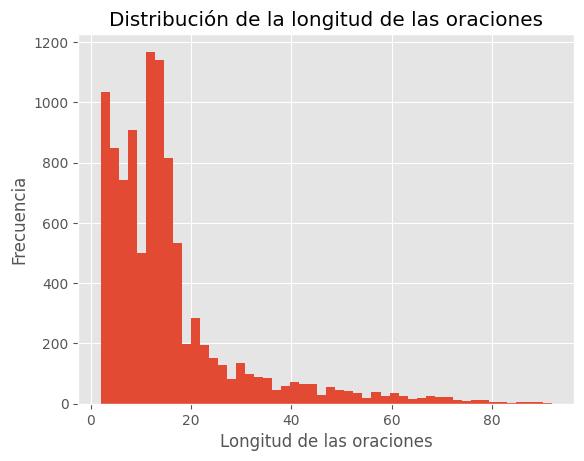



------------------------- Gráfica Testeo ----------------------------



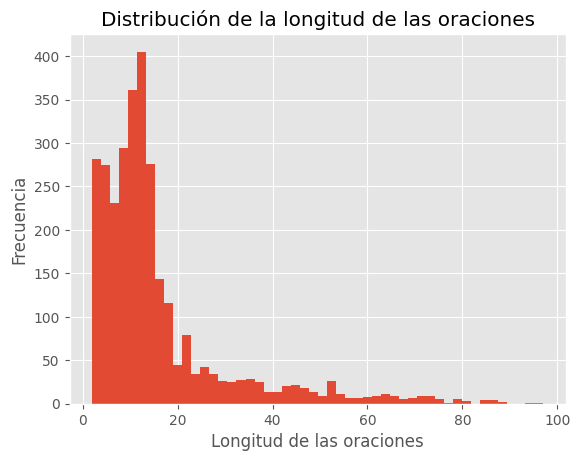

In [11]:
print("------------------------- Gráfica Entrenamiento -------------------------\n")
graficar_numero_palabras(corpus_OCR_train)
print("\n\n------------------------- Gráfica Testeo ----------------------------\n")
graficar_numero_palabras(corpus_OCR_test)

# **Verificar la oración más larga del conjunto de entrenamiento y de testeo**

In [12]:
def oracion_mas_larga(corpus_OCR, max_words_len):
    oraciones_mas_largas = [x for x in corpus_OCR if len(x.split()) > max_words_len]

    if not oraciones_mas_largas:
        print(f"No se encontraron oraciones con más de {max_words_len} palabras")
        return
    oracion_mas_larga = max(oraciones_mas_largas, key=lambda x: len(x.split()))
    num_palabras_oracion = len(oracion_mas_larga.split())

    print(f"Número de palabras en la oración más larga: {num_palabras_oracion}")
    print(oracion_mas_larga)

In [13]:
print("------------------------- Oración más larga Entrenamiento -------------------------\n")
oracion_mas_larga(corpus_OCR_train, max_words_len)
print("\n\n------------------------- Oración más larga Testeo ----------------------------\n")
oracion_mas_larga(corpus_OCR_test, max_words_len)

------------------------- Oración más larga Entrenamiento -------------------------

Número de palabras en la oración más larga: 92
fundamentally the best way to deal with merge conflicts is to so far as is possible ensure they don t happen in the first place you can improve your odd on this by keeping branches clean and focused on a single issue and involving as few files as possible before merging make sure you know what s in both branches and if you are not the only one that has worked on the branches then keep the lines of communication open so you are all aware of what the others are doing


------------------------- Oración más larga Testeo ----------------------------

Número de palabras en la oración más larga: 97
thankfully we don t have to worry about those equations because a ray tracer s approach to modeling light is very simple what we do have to worry about are the different types of light sources that we can have in a scene as an experiment look around and count the numb

# **División de las oraciones**
Si la oración es mayor al número definido anteriomente se aplica una división para crear más muestras en el conjunto de entrenamiento

In [14]:
def split_sentences(corpus_OCR, corpus_REF, etiqueta, max_words_len):
    new_sentence1 = []
    new_sentence2 = []
    new_etiqueta = []

    for i in range(0, len(corpus_OCR)):
        sentence1_words = corpus_OCR[i].split()
        sentence2_words = corpus_REF[i].split()
        etiqueta_words = etiqueta[i]

        num_fragments = math.ceil(len(sentence1_words)/max_words_len)
        new_fragment_size = math.ceil(len(sentence1_words)/num_fragments)

        sentence1_fragments = [' '.join(sentence1_words[j:j+new_fragment_size]) for j in range(0, len(sentence1_words), new_fragment_size)]
        sentence2_fragments = [' '.join(sentence2_words[j:j+new_fragment_size]) for j in range(0, len(sentence2_words), new_fragment_size)]
        etiqueta_fragments = [etiqueta_words[j:j+new_fragment_size] for j in range(0, len(etiqueta_words), new_fragment_size)]

        new_sentence1.extend(sentence1_fragments)
        new_sentence2.extend(sentence2_fragments)
        new_etiqueta.extend(etiqueta_fragments)

    return new_sentence1, new_sentence2, new_etiqueta

In [15]:
print("------------------------- Split Entrenamiento -------------------------")
corpus_OCR_train, corpus_REF_train, etiqueta_train = split_sentences(corpus_OCR_train, corpus_REF_train, etiqueta_train, max_words_len)
print(len(corpus_OCR_train), len(corpus_REF_train), len(etiqueta_train))
print("\n------------------------- Split Testeo -------------------------")
corpus_OCR_test, corpus_REF_test, etiqueta_test = split_sentences(corpus_OCR_test, corpus_REF_test, etiqueta_test, max_words_len)
print(len(corpus_OCR_test), len(corpus_REF_test), len(etiqueta_test))

------------------------- Split Entrenamiento -------------------------
12940 12940 12940

------------------------- Split Testeo -------------------------
3900 3900 3900


------------------------- Gráfica Entrenamiento -------------------------



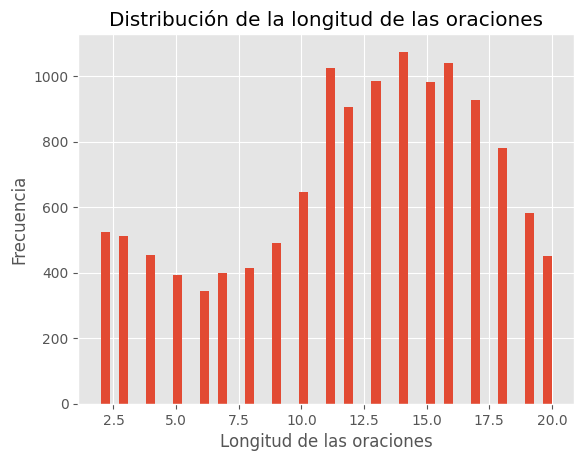



------------------------- Gráfica Testeo ----------------------------



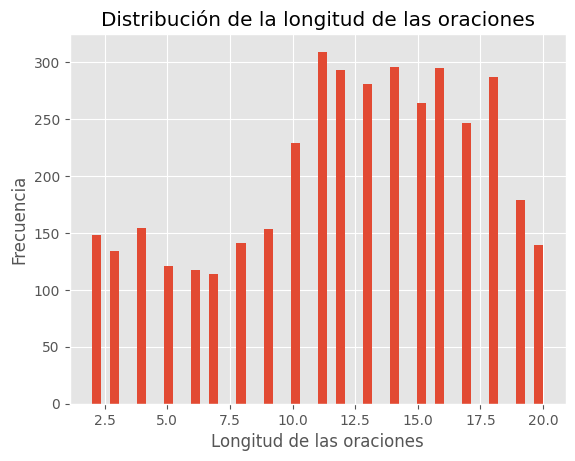

In [16]:
print("------------------------- Gráfica Entrenamiento -------------------------\n")
graficar_numero_palabras(corpus_OCR_train)
print("\n\n------------------------- Gráfica Testeo ----------------------------\n")
graficar_numero_palabras(corpus_OCR_test)

In [17]:
print("------------------------- Oración más larga Entrenamiento -------------------------")
oracion_mas_larga(corpus_OCR_train, max_words_len)
print("\n------------------------- Oración más larga Testeo ----------------------------")
oracion_mas_larga(corpus_OCR_test, max_words_len)

------------------------- Oración más larga Entrenamiento -------------------------
No se encontraron oraciones con más de 20 palabras

------------------------- Oración más larga Testeo ----------------------------
No se encontraron oraciones con más de 20 palabras


In [18]:
def igualar_oraciones(corpus_OCR, corpus_REF):
    etiqueta = []
    new_sentences_OCR = []
    new_sentences_REF = []

    for sentence_OCR, sentence_REF in zip(corpus_OCR, corpus_REF):
        fila_resultados = []
        new_sentence_OCR = []
        new_sentence_REF = []

        words_OCR = sentence_OCR.split(" ")
        words_REF = sentence_REF.split(" ")

        for word_OCR, word_REF in zip(words_OCR, words_REF):
            if word_OCR == '':
                new_sentence_OCR.append('')
                new_sentence_REF.append(word_REF)
            elif word_REF == '':
                new_sentence_OCR.append(word_OCR)
                new_sentence_REF.append('_')
            else:
                fila_resultados.append(1 if word_OCR == word_REF else 0)
                new_sentence_OCR.append(word_OCR)
                new_sentence_REF.append(word_REF)

        etiqueta.append(fila_resultados)
        new_sentences_OCR.append(' '.join(new_sentence_OCR))
        new_sentences_REF.append(' '.join(new_sentence_REF))

    return new_sentences_OCR, new_sentences_REF, etiqueta

In [19]:
corpus_OCR_train, corpus_REF_train, etiqueta_train = igualar_oraciones(corpus_OCR_train, corpus_REF_train)
corpus_OCR_test, corpus_REF_test, etiqueta_test = igualar_oraciones(corpus_OCR_test, corpus_REF_test)

In [20]:
for i in range(len(corpus_OCR_train)):
    if(len(corpus_OCR_train[i].split()) != len(corpus_REF_train[i].split())):
        print(len(corpus_OCR_train[i].split()), corpus_OCR_train[i], " - ", len(corpus_REF_train[i].split()), corpus_REF_train[i])
for i in range(len(corpus_OCR_test)):
    if(len(corpus_OCR_test[i].split()) != len(corpus_REF_test[i].split())):
        print(len(corpus_OCR_test[i].split()), corpus_OCR_test[i], " - ", len(corpus_REF_test[i].split()), corpus_REF_test[i])

# **Función para obtener los ids de los tokens**
Obtención de los ids de cada palabra, exclusión de las etiquetas cls y sep.
Recorte del conjunto de datos que sean mayor al número de tokens definido anteriormente.

In [21]:
def transform_sentences(transform, corpus_OCR, corpus_REF, etiqueta):

    sentence_transform_OCR = []
    sentence_transform_REF = []
    etiquetas_desc = []

    for (sentence_OCR, sentence_REF, etiquetas) in zip(corpus_OCR, corpus_REF, etiqueta):
        sentenceOCR = transform([sentence_OCR])
        sentenceREF = transform([sentence_REF])

        words_OCR = sentenceOCR[0]
        words_REF = sentenceREF[0]

        sentences_OCR = words_OCR[1:-1]
        sentences_REF = words_REF[1:-1]

        if(len(sentences_OCR) <= max_len and len(sentences_OCR) >= 3):
            sentence_transform_OCR.append(sentences_OCR)
            sentence_transform_REF.append(sentences_REF)
            etiquetas_desc.append(etiquetas)

    return sentence_transform_OCR, sentence_transform_REF, etiquetas_desc

# **Función para la asignación de etiquetas a tokens wordpiece**
Al realizar el proceso anterior se obtienen tokens con respecto a wordpiece, a esta separación se le agregan las etiquetas pertenecientes a la palabra completa

In [22]:
def wordpiece_labels(sentence_transform, vocab, etiqueta):
    new_etiquetas = []
    pos_new_etiquetas = []

    for i, (token_ids, orig_etiquetas) in enumerate(zip(sentence_transform, etiqueta)):
        tokens = [vocab.to_tokens(int(token_id)) for token_id in token_ids]
        current_etiqueta = None
        new_etiqueta = []
        pos_new_etiqueta = []

        etiqueta_idx = 0
        count = 0
        for j, token in enumerate(tokens):
            if etiqueta_idx < len(orig_etiquetas):
                if not re.search(r'^##', token):
                    current_etiqueta = orig_etiquetas[etiqueta_idx]
                    etiqueta_idx += 1
                    count += 1
                    pos = count - 1
            new_etiqueta.append(current_etiqueta)
            pos_new_etiqueta.append(pos)
        new_etiquetas.append(new_etiqueta)
        pos_new_etiquetas.append(pos_new_etiqueta)

    if(len(tokens) != len(new_etiqueta)):
        print(orig_etiquetas)
        print(len(orig_etiquetas))
        print(tokens)
        print(len(tokens))
        print(new_etiqueta)
        print(len(new_etiqueta))
        print("")

    return new_etiquetas, pos_new_etiquetas

# **Creación de la data para entrenamiento**
Creación de las entradas para el modelo y obtención de la distribución de la frecuencia de cada clase.

In [23]:
def data_pretrain(sentences_transform_OCR, sentences_transform_REF, vocab, etiqueta, ctx):
    labels_wordpiece, orig_etiquetas_positions = wordpiece_labels(sentences_transform_OCR, vocab, etiqueta)
    pretrain, total_labels, REF_tokens, orig_etiquetas_positions_excl = [], [], [], []

    for i in range(len(labels_wordpiece)):
        # Si la palabra no contiene al menos un 0 (clase incorrecta) se exluye del entrenamiento
        if 0 in labels_wordpiece[i]:
            tokens_OCR = sentences_transform_OCR[i]
            tokens_REF = sentences_transform_REF[i]

            token_ids = [*tokens_OCR]
            token_ids_ref = [*tokens_REF]
            valid_len = len(token_ids)
            segments = [0] * valid_len
            labels = [*labels_wordpiece[i]]
            pos_etiquetas = [*orig_etiquetas_positions[i]]

            total_labels.append(labels)

            train = (token_ids, segments, valid_len, labels)
            pretrain.append(train)
            REF_tokens.append(token_ids_ref)
            orig_etiquetas_positions_excl.append(pos_etiquetas)

    # Las entradas deben tener un número divisible para el número de dispositivos a usarse
    # Se elimina aleatoriamente el número excedentes si el módulo entre pretrain y los dispositivos no es cero
    num_ctx = len(ctx)
    remainder = len(pretrain) % num_ctx
    if remainder != 0:
        samples_to_remove = remainder
        for _ in range(samples_to_remove):
            random_index = random.randint(0, len(pretrain) - 1)
            del pretrain[random_index]
            del total_labels[random_index]
            del REF_tokens[random_index]
            del orig_etiquetas_positions_excl[random_index]

    # Cálculo de pesos de cada clase
    cont_clase_1 = 0
    cont_clase_0 = 0

    for labels in total_labels:
        for label in labels:
            if label == 1:
                cont_clase_1 += 1
            else:
                cont_clase_0 += 1

    total = cont_clase_1 + cont_clase_0

    peso_clase_0 = cont_clase_0 / total
    peso_clase_1 = cont_clase_1 / total

    class_weights = mx.nd.array([peso_clase_0, peso_clase_1], ctx=mx.cpu(0)) # ([0, 1])

    return pretrain, class_weights, REF_tokens, orig_etiquetas_positions_excl

# **Asignación etiquetas de relleno**
Completa cada muestra con el número de etiquetas de relleno faltantes y forma los tensores mxnet

In [24]:
def pad_bert_inputs(pretrain, max_len, vocab):
    all_token_ids, all_segments, all_valid_len, all_labels = [], [], [], []

    for (token_ids, segments, valid_len, labels) in pretrain:
        all_token_ids.append(token_ids + [vocab['[PAD]']] * (max_len - len(token_ids)))
        all_segments.append(segments + [0] * (max_len - len(token_ids)))
        all_valid_len.append(valid_len)
        all_labels.append(labels + [-1] * (max_len - len(token_ids)))

    all_token_ids_mx = mx.nd.array(all_token_ids, ctx=mx.cpu(0))
    all_segments_mx = mx.nd.array(all_segments, ctx=mx.cpu(0))
    all_valid_len_mx = mx.nd.array(all_valid_len,  ctx=mx.cpu(0))
    all_labels_mx = mx.nd.array(all_labels, ctx=mx.cpu(0))

    return (all_token_ids_mx, all_segments_mx, all_valid_len_mx, all_labels_mx)

# **Proceso completo para las entradas del modelo**
Aplicación de funciones anteriores.
Aplicación de FixedBucketSampler para formar grupos de batches definidos por el tamaño de valid_len.
Creación de DataLoader.

In [25]:
def load_data_wiki(corpus_OCR, corpus_REF, etiqueta, batch_size, max_len, vocab, ctx):
    num_workers = d2l.get_dataloader_workers()
    sentences_transform_OCR, sentences_transform_REF, etiquetas = transform_sentences(transform, corpus_OCR, corpus_REF, etiqueta)
    pretrain, class_weights, REF_tokens, orig_etiquetas_positions = data_pretrain(sentences_transform_OCR, sentences_transform_REF, vocab, etiquetas, ctx)
    print(len(pretrain))
    data_padded = pad_bert_inputs(pretrain, max_len, vocab)
    dataset = gluon.data.ArrayDataset(*data_padded)

    data_loader = gluon.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
    return data_loader, class_weights, REF_tokens, orig_etiquetas_positions, pretrain

In [26]:
train_loader, class_weights_train, REF_tokens_train, orig_etiquetas_positions_train, pretrain = load_data_wiki(corpus_OCR_train, corpus_REF_train, etiqueta_train, batch_size, max_len, vocab, ctx)
test_loader, class_weights_test, REF_tokens_test, orig_etiquetas_positions_test, pretest = load_data_wiki(corpus_OCR_test, corpus_REF_test, etiqueta_test, batch_size, max_len, vocab, ctx)

7688
2304


In [27]:
print(len(REF_tokens_train))
print(len(REF_tokens_test))

7688
2304


In [28]:
print("\nclass_weights_train: ", class_weights_train)
print("\nclass_weights_test: ", class_weights_test)

total_weights = class_weights_train + class_weights_test

total_weights = total_weights / mx.nd.sum(total_weights)
print("\ntotal_weights: ", total_weights)


class_weights_train:  
[0.22543146 0.77456856]
<NDArray 2 @cpu(0)>

class_weights_test:  
[0.23784421 0.7621558 ]
<NDArray 2 @cpu(0)>

total_weights:  
[0.23163784 0.76836216]
<NDArray 2 @cpu(0)>


# **Definición de la clase aplicando fine tuning para la clasificación binaria.**
Clase para la clasificación binaria partiendo de las salidas del modelo preentrenado.

In [29]:
class WordClassificationModel(gluon.HybridBlock):
    def __init__(self, bert_model, num_classes):
        super(WordClassificationModel, self).__init__()
        with self.name_scope():
            self.bert_model = bert_model

            self.classifier = gluon.nn.HybridSequential()
            self.classifier.add(gluon.nn.Dense(units=768, flatten=False))
            self.classifier.add(gluon.nn.GELU())
            self.classifier.add(gluon.nn.LayerNorm(epsilon=1e-12))
            self.classifier.add(gluon.nn.Dense(units=num_classes, flatten=False))

    def forward(self, input_ids, segments, valid_len):
        bert_output, _ = self.bert_model(input_ids, segments, valid_len)

        logits = self.classifier(bert_output)

        return logits

# **Inicialización**
Inicializa el modelo, las capas aplicadas a fine tuning. Congelamiento de las capas del modelo preentrenado. Intancia del optimizador, la función de pérdida y el entrenador (trainer)

In [30]:
word_classification_model = WordClassificationModel(model, num_classes)

for param in word_classification_model.bert_model.collect_params().values():
    param.grad_req = 'null'

word_classification_model.classifier.initialize(ctx=ctx)

optimizer = mx.optimizer.Adam(learning_rate=lr)

loss_function = mx.gluon.loss.SoftmaxCrossEntropyLoss()

trainer = gluon.Trainer(word_classification_model.collect_params(), optimizer)

# **Función para el entrenamiento y el cálculo de la pérdida a nivel de batch y dispositivos**

In [31]:
def get_batch_loss(word_classification_model, loss_function, token_ids_shards, segments_shards, valid_len_shards,
                   labels_shards):
    ls = []
    outs = []

    for (token_ids_shard, segments_shard, valid_len_shard, labels_shard) in zip(token_ids_shards, segments_shards,
                                                                                valid_len_shards, labels_shards):
        out = word_classification_model(token_ids_shard, segments_shard, valid_len_shard)

        masked_losses = []
        for i in range(out.shape[0]):
            loss = loss_function(out[i], labels_shard[i])
            mask = (labels_shard[i] != -1).astype(out.dtype)
            masked_loss = ((loss * mask).sum() / mask.sum())
            masked_losses.append(masked_loss)
        # Calcular el promedio de masked_losses y agregarlo a ls
        average_loss = sum(masked_losses) / len(masked_losses)
        ls.append(average_loss)

        outs.append(out)
    mx.nd.waitall()
    return ls, outs

# **Función de evaluación del modelo**

In [32]:
def evaluate_model(model, data_loader, loss_function, ctx):
    metric = d2l.Accumulator(3)
    batch_predictions, batch_labels, batch_probabilities = [], [], []

    for batch in data_loader:
        (token_ids_shards, segments_shards, valid_len_shards, labels_shards) =
        [gluon.utils.split_and_load(elem, ctx, even_split=False) for elem in batch]

        ls, outs = get_batch_loss(model, loss_function, token_ids_shards, segments_shards, valid_len_shards, labels_shards)

        l_mean = sum([float(l.asscalar()) for l in ls]) / len(ls)

        metric.add(l_mean, batch[0].shape[0], 1)

        for (out, labels_shard, valid_len_shard) in zip(outs, labels_shards, valid_len_shards):
            probabilities = mx.nd.softmax(out, axis=-1)
            predictions = probabilities.argmax(axis=-1)

            batch_predictions.append(predictions.asnumpy())
            batch_labels.append(labels_shard.asnumpy())
            batch_probabilities.append(probabilities.asnumpy())

    test_loss = metric[0] / metric[2]

    batch_predictions = np.concatenate(batch_predictions)
    batch_labels = np.concatenate(batch_labels)
    batch_probabilities = np.concatenate(batch_probabilities)

    return test_loss, batch_predictions, batch_labels, batch_probabilities

# **Rutina de entrenamiento del modelo**

37524.96459841728

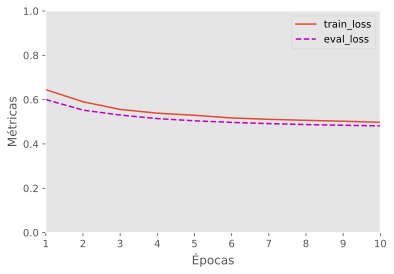

In [33]:
train_epoch_predictions, train_epoch_labels, train_epoch_probabilities = [], [], []
eval_epoch_predictions, eval_epoch_labels, eval_epoch_probabilities = [], [], []

total_timer = d2l.Timer()

animator = d2l.Animator(xlabel='Épocas', ylabel='Métricas', xlim=[1, num_epochs], ylim=[0.0, 1.0],
                        legend=['train_loss', 'eval_loss', 'train_acc'], figsize=(6, 4))

for epoch_id in range(num_epochs):
    metric = d2l.Accumulator(3)
    batch_predictions, batch_labels, batch_probabilities = [], [], []

    for batch in train_loader:
        (token_ids_shards, segments_shards, valid_len_shards, labels_shards) =
        [gluon.utils.split_and_load(elem, ctx, even_split=False) for elem in batch]

        with mx.autograd.record():
            ls, outs = get_batch_loss(word_classification_model, loss_function, token_ids_shards,
                                      segments_shards, valid_len_shards, labels_shards)

        for l in ls:
            l.backward()

        trainer.step(1)

        l_mean = sum([float(l.asscalar()) for l in ls]) / len(ls)

        for (out, labels_shard) in zip(outs, labels_shards):
            probabilities = mx.nd.softmax(out, axis=-1)
            predictions = probabilities.argmax(axis=-1)

            batch_predictions.append(predictions.asnumpy())
            batch_labels.append(labels_shard.asnumpy())
            batch_probabilities.append(probabilities.asnumpy())

        metric.add(l_mean, batch[0].shape[0], 1)

    train_loss = metric[0] / metric[2]

    epoch_predictions = np.concatenate(batch_predictions)
    epoch_labels = np.concatenate(batch_labels)
    epoch_probabilities = np.concatenate(batch_probabilities)

    train_epoch_predictions.append(epoch_predictions)
    train_epoch_labels.append(epoch_labels)
    train_epoch_probabilities.append(epoch_probabilities)

    test_loss, test_predictions, test_labels, test_probabilities = evaluate_model(word_classification_model,
                                                                                  test_loader, loss_function, ctx)
    eval_epoch_predictions.append(test_predictions)
    eval_epoch_labels.append(test_labels)
    eval_epoch_probabilities.append(test_probabilities)

    animator.add(epoch_id + 1, (train_loss, test_loss))

total_timer.stop()

# **Cálculo de métricas para entrenamiento y para evaluación**

# **Función para unir palabras debido a la tokenización con Wordpiece**

In [34]:
def tokens_to_string(tokens):
    processed_tokens = []
    for token in tokens:
        # Eliminar "##" y pegar al token anterior
        if (token.startswith("##")):
            processed_tokens[-1] += token[2:]
        else:
            processed_tokens.append(token)
    return ' '.join(processed_tokens)

# **Función para organizar las etiquetas con las posiciones originales antes de la aplicación de Wordpiece**

In [35]:
def organizar_tokens_predicciones(pos, etiquetas):
    diccionario_etiquetas = {}

    for i in range(len(pos)):
        if i > 0 and pos[i] == pos[i-1]:
            # Si la posición es igual a la anterior, asigna la etiqueta según las condiciones
            if etiquetas[i] == 'incorrecto':
                diccionario_etiquetas[pos[i]] = 'incorrecto'
        else:
            diccionario_etiquetas[pos[i]] = etiquetas[i]

    etiquetas_finales = [diccionario_etiquetas[i] for i in sorted(diccionario_etiquetas)]

    return ' '.join(etiquetas_finales)

# **Métricas Entrenamiento**

Obtención de las métricas anteriores definidas a nivel de época, esto para obtener una gráfica de métricas.



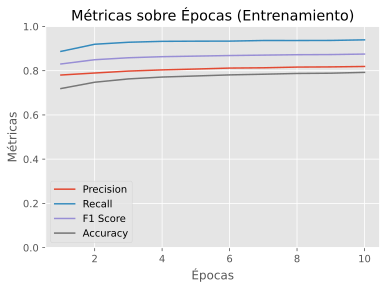

In [36]:
precision_list_train, recall_list_train, f1_list_train, accuracy_list_train = [], [], [], []

for i in range(len(train_epoch_labels)):  # Recorrido por época
    TP_epoch, TN_epoch, FP_epoch, FN_epoch = 0, 0, 0, 0

    for j in range(len(train_epoch_labels[i])):  # Recorrido por muestras en cada época
        valid_indices = np.where(train_epoch_labels[i][j] != -1) # exlcusión de etiquetas [PAD] == -1

        valid_train_epoch_labels = train_epoch_labels[i][j][valid_indices]
        valid_train_epoch_predictions = train_epoch_predictions[i][j][valid_indices]

        TP, TN, FP, FN = 0, 0, 0, 0

        # Calcula TP, TN, FP, FN para la época actual
        for idx in range(len(valid_train_epoch_labels)):
            if valid_train_epoch_labels[idx] == 1 and valid_train_epoch_predictions[idx] == 1:
                TP += 1
            elif valid_train_epoch_labels[idx] == 0 and valid_train_epoch_predictions[idx] == 0:
                TN += 1
            elif valid_train_epoch_labels[idx] == 0 and valid_train_epoch_predictions[idx] == 1:
                FP += 1
            elif valid_train_epoch_labels[idx] == 1 and valid_train_epoch_predictions[idx] == 0:
                FN += 1

        TP_epoch += TP
        TN_epoch += TN
        FP_epoch += FP
        FN_epoch += FN

    # Calcula las métricas para la época actual usando fórmulas
    precision = TP_epoch / (TP_epoch + FP_epoch) if (TP_epoch + FP_epoch) != 0 else 0
    recall = TP_epoch / (TP_epoch + FN_epoch) if (TP_epoch + FN_epoch) != 0 else 0
    accuracy = (TP_epoch + TN_epoch) / (TP_epoch + TN_epoch + FP_epoch + FN_epoch)
                if (TP_epoch + TN_epoch+ FP_epoch + FN_epoch) != 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Almacena las métricas para la época actual
    precision_list_train.append(precision)
    recall_list_train.append(recall)
    f1_list_train.append(f1)
    accuracy_list_train.append(accuracy)

# Crea una gráfica de las métricas a lo largo de las épocas
epochs = range(1, len(train_epoch_labels) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, precision_list_train, label='Precision')
plt.plot(epochs, recall_list_train, label='Recall')
plt.plot(epochs, f1_list_train, label='F1 Score')
plt.plot(epochs, accuracy_list_train, label='Accuracy')

plt.xlabel('Épocas')
plt.ylabel('Métricas')
plt.legend()
plt.title('Métricas sobre Épocas (Entrenamiento)')
plt.ylim(0, 1)
plt.show()

In [37]:
print("precision last epoch: ", precision_list_train[-1])
print("recall last epoch: ", recall_list_train[-1])
print("f1 last epoch: ", f1_list_train[-1])
print("accuracy last epoch:", accuracy_list_train[-1])

precision last epoch:  0.8190756415702283
recall last epoch:  0.9394555155490595
f1 last epoch:  0.8751452893056001
accuracy last epoch: 0.7923696442542225


In [38]:
conf_matrix_list_train = []

for i in range(len(train_epoch_labels)): # obtiene cada epoca
    conf_matrix_epoch = []

    for j in range(len(train_epoch_labels[i])): # obtiene todas las muestras de una época
        valid_indices = np.where(train_epoch_labels[i][j] != -1) # [PAD] == -1

        valid_train_epoch_labels = train_epoch_labels[i][j][valid_indices]
        valid_train_epoch_predictions = train_epoch_predictions[i][j][valid_indices]

        conf_matrix = confusion_matrix(valid_train_epoch_predictions, valid_train_epoch_labels)

        conf_matrix_epoch.append(conf_matrix)

    conf_matrix_list_train.append(conf_matrix_epoch)

# **Matriz de confusión aplicada a los valores de la última época**

In [39]:
train_epoch_labels_np = np.array(train_epoch_labels[-1])
train_epoch_predictions_np = np.array(train_epoch_predictions[-1])

valid_indices_train = np.where(train_epoch_labels_np != -1)

filtered_train_predictions = train_epoch_labels_np[valid_indices_train]
filtered_train_labels = train_epoch_predictions_np[valid_indices_train]

train_conf_matrix = confusion_matrix(filtered_train_predictions, filtered_train_labels)

In [40]:
# Extraer valores de la matriz de confusión
TN_train, FP_train, FN_train, TP_train = train_conf_matrix.ravel()

# Crear DataFrame con los valores
conf_matrix_df_train = pd.DataFrame([[TN_train, FP_train], [FN_train, TP_train]],
                                     columns=["Predicción Negativa", "Predicción Positiva"],
                                     index=["Actual Negativa", "Actual Positiva"])

# Agregar detalle de TP, TN, FP, FN a los valores de la matriz de confusión
conf_matrix_df_train.loc["Actual Negativa", "Predicción Negativa"] = f"{TN_train} (TN)"
conf_matrix_df_train.loc["Actual Negativa", "Predicción Positiva"] = f"{FP_train} (FP)"
conf_matrix_df_train.loc["Actual Positiva", "Predicción Negativa"] = f"{FN_train} (FN)"
conf_matrix_df_train.loc["Actual Positiva", "Predicción Positiva"] = f"{TP_train} (TP)"

# Mostrar la matriz de confusión con print
display(conf_matrix_df_train)

,Predicción Negativa,Predicción Positiva
Actual Negativa,7029 (TN),17463 (FP)
Actual Positiva,5095 (FN),79058 (TP)


In [41]:
list_TN_train, list_FP_train, list_FN_train, list_TP_train = [], [], [], []

for i in range(len(conf_matrix_list_train)):
    epoch_TN, epoch_FP, epoch_FN, epoch_TP = [], [], [], []
    for j in range(len(conf_matrix_list_train[i])):
        if(len(conf_matrix_list_train[i][j]) == 2):
            epoch_TN.append(conf_matrix_list_train[i][j][0][0])
            epoch_FP.append(conf_matrix_list_train[i][j][0][1])
            epoch_FN.append(conf_matrix_list_train[i][j][1][0])
            epoch_TP.append(conf_matrix_list_train[i][j][1][1])
        else:
            epoch_TN.append(conf_matrix_list_train[i][j][0][0])
            epoch_FP.append(0)
            epoch_FN.append(0)
            epoch_TP.append(0)
    list_TN_train.append(epoch_TN)
    list_FP_train.append(epoch_FP)
    list_FN_train.append(epoch_FN)
    list_TP_train.append(epoch_TP)

In [42]:
data = {
    'Reference': [],
    'Prediction': [],
    'TP': [],
    'TN': [],
    'FP': [],
    'FN': [],
    'Token ids (reference)': [],
    'Token ids (prediction)': [],
    'Tokens (reference)': [],
    'Tokens (prediction)': [],
    'Words (reference)': [],
    'Words (prediction)': [],
    'Tokens (OCR)': [],
    'Token ids (OCR)': [],
    'Words (OCR)': [],
}

In [43]:
for i in range(len(train_epoch_labels[-1])):
    valid_indices_train = np.where(train_epoch_labels[-1][i] != -1)
    primera_columna = train_epoch_labels[-1][i][valid_indices_train].astype(int).tolist()
    segunda_columna = train_epoch_predictions[-1][i][valid_indices_train].astype(int).tolist()
    tercera_columna = list_TP_train[-1][i]
    cuarta_columna = list_TN_train[-1][i]
    quinta_columna = list_FP_train[-1][i]
    sexta_columna = list_FN_train[-1][i]
    septima_columna = REF_tokens_train[i]
    octava_columna = segunda_columna
    tokens_ref = [vocab.idx_to_token[token_id] for token_id in REF_tokens_train[i]]
    novena_columna = tokens_ref
    label_values_token = ["correcto" if val == 1 else "incorrecto" for val in train_epoch_predictions[-1][i][valid_indices_train]]
    decima_columna = label_values_token
    processed_tokens_ref = tokens_to_string(tokens_ref)
    decimo_primer_columna = processed_tokens_ref
    decimo_segunda_columna = organizar_tokens_predicciones(orig_etiquetas_positions_train[i], label_values_token)
    decimo_tercer_columna = pretrain[i][0]
    tokens_ocr = [vocab.idx_to_token[token_id] for token_id in pretrain[i][0]]
    decimo_cuarta_columna = tokens_ocr
    processed_tokens_ocr = tokens_to_string(tokens_ocr)
    decimo_quinta_columna = processed_tokens_ocr

    # Agrega los valores al diccionario
    data['Reference'].append(primera_columna)
    data['Prediction'].append(segunda_columna)
    data['TP'].append(tercera_columna)
    data['TN'].append(cuarta_columna)
    data['FP'].append(quinta_columna)
    data['FN'].append(sexta_columna)
    data['Token ids (reference)'].append(septima_columna)
    data['Token ids (prediction)'].append(octava_columna)
    data['Tokens (reference)'].append(novena_columna)
    data['Tokens (prediction)'].append(decima_columna)
    data['Words (reference)'].append(decimo_primer_columna)
    data['Words (prediction)'].append(decimo_segunda_columna)
    data['Tokens (OCR)'].append(decimo_tercer_columna)
    data['Token ids (OCR)'].append(decimo_cuarta_columna)
    data['Words (OCR)'].append(decimo_quinta_columna)

In [44]:
df = pd.DataFrame(data)

df.to_excel('Excel_Reporte/resultados_entrenamiento_modelo_2.xlsx', index=False)

# **Métricas Evaluación**

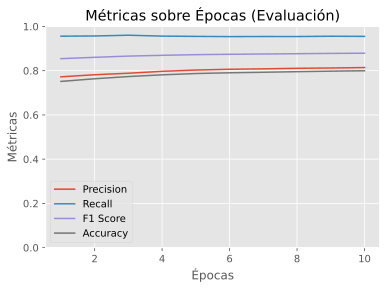

In [45]:
precision_list_eval, recall_list_eval, f1_list_eval, accuracy_list_eval = [], [], [], []

for i in range(len(eval_epoch_labels)):  # Recorrido por época
    TP_epoch, TN_epoch, FP_epoch, FN_epoch = 0, 0, 0, 0

    for j in range(len(eval_epoch_labels[i])):  # Recorrido por muestras en cada época
        valid_indices = np.where(eval_epoch_labels[i][j] != -1) # exlcusión de etiquetas [PAD] == -1

        valid_eval_epoch_labels = eval_epoch_labels[i][j][valid_indices]
        valid_eval_epoch_predictions = eval_epoch_predictions[i][j][valid_indices]

        TP, TN, FP, FN = 0, 0, 0, 0

        # Calcula TP, TN, FP, FN para la época actual
        for idx in range(len(valid_eval_epoch_labels)):
            if valid_eval_epoch_labels[idx] == 1 and valid_eval_epoch_predictions[idx] == 1:
                TP += 1
            elif valid_eval_epoch_labels[idx] == 0 and valid_eval_epoch_predictions[idx] == 0:
                TN += 1
            elif valid_eval_epoch_labels[idx] == 0 and valid_eval_epoch_predictions[idx] == 1:
                FP += 1
            elif valid_eval_epoch_labels[idx] == 1 and valid_eval_epoch_predictions[idx] == 0:
                FN += 1

        TP_epoch += TP
        TN_epoch += TN
        FP_epoch += FP
        FN_epoch += FN

    # Calcula las métricas para la época actual usando fórmulas
    precision = TP_epoch / (TP_epoch + FP_epoch) if (TP_epoch + FP_epoch) != 0 else 0
    recall = TP_epoch / (TP_epoch + FN_epoch) if (TP_epoch + FN_epoch) != 0 else 0
    accuracy = (TP_epoch + TN_epoch) / (TP_epoch + TN_epoch + FP_epoch + FN_epoch) if (TP_epoch + TN_epoch + FP_epoch + FN_epoch) != 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    # Almacena las métricas para la época actual
    precision_list_eval.append(precision)
    recall_list_eval.append(recall)
    f1_list_eval.append(f1)
    accuracy_list_eval.append(accuracy)

# Crea una gráfica de las métricas a lo largo de las épocas
epochs = range(1, len(eval_epoch_labels) + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, precision_list_eval, label='Precision')
plt.plot(epochs, recall_list_eval, label='Recall')
plt.plot(epochs, f1_list_eval, label='F1 Score')
plt.plot(epochs, accuracy_list_eval, label='Accuracy')

plt.xlabel('Épocas')
plt.ylabel('Métricas')
plt.legend()
plt.title('Métricas sobre Épocas (Evaluación)')
plt.ylim(0, 1)
plt.show()

In [46]:
print("precision last epoch: ", precision_list_eval[-1])
print("recall last epoch: ", recall_list_eval[-1])
print("f1 last epoch: ", f1_list_eval[-1])
print("accuracy last epoch:", accuracy_list_eval[-1])

precision last epoch:  0.8141648168701443
recall last epoch:  0.9550817804540647
f1 last epoch:  0.8790114210821943
accuracy last epoch: 0.7996154800297693


In [47]:
conf_matrix_list_eval = []

for i in range(len(eval_epoch_labels)): # obtiene cada epoca
    conf_matrix_epoch = []

    for j in range(len(eval_epoch_labels[i])): # obtiene todas las muestras de una época
        valid_indices = np.where(eval_epoch_labels[i][j] != -1) # [PAD] == -1

        valid_eval_epoch_labels = eval_epoch_labels[i][j][valid_indices]
        valid_eval_epoch_predictions = eval_epoch_predictions[i][j][valid_indices]

        conf_matrix = confusion_matrix(valid_eval_epoch_predictions, valid_eval_epoch_labels)

        conf_matrix_epoch.append(conf_matrix)

    conf_matrix_list_eval.append(conf_matrix_epoch)

In [48]:
eval_epoch_labels_np = np.array(eval_epoch_labels[-1])
eval_epoch_predictions_np = np.array(eval_epoch_predictions[-1])

valid_indices_eval = np.where(eval_epoch_labels_np != -1)

filtered_eval_predictions = eval_epoch_labels_np[valid_indices_eval]
filtered_eval_labels = eval_epoch_predictions_np[valid_indices_eval]

eval_conf_matrix = confusion_matrix(filtered_eval_predictions, filtered_eval_labels)

In [49]:
# Extraer valores de la matriz de confusión
TN_eval, FP_eval, FN_eval, TP_eval = eval_conf_matrix.ravel()

# Crear DataFrame con los valores
conf_matrix_df_eval = pd.DataFrame([[TN_eval, FP_eval], [FN_eval, TP_eval]],
                                     columns=["Predicción Negativa", "Predicción Positiva"],
                                     index=["Actual Negativa", "Actual Positiva"])

# Agregar detalle de TP, TN, FP, FN a los valores de la matriz de confusión
conf_matrix_df_eval.loc["Actual Negativa", "Predicción Negativa"] = f"{TN_eval} (TN)"
conf_matrix_df_eval.loc["Actual Negativa", "Predicción Positiva"] = f"{FP_eval} (FP)"
conf_matrix_df_eval.loc["Actual Positiva", "Predicción Negativa"] = f"{FN_eval} (FN)"
conf_matrix_df_eval.loc["Actual Positiva", "Predicción Positiva"] = f"{TP_eval} (TP)"

# Mostrar la matriz de confusión con print
display(conf_matrix_df_eval)

,Predicción Negativa,Predicción Positiva
Actual Negativa,2312 (TN),5358 (FP)
Actual Positiva,1104 (FN),23474 (TP)


In [50]:
list_TN_eval, list_FP_eval, list_FN_eval, list_TP_eval = [], [], [], []

for i in range(len(conf_matrix_list_eval)):
    epoch_TN, epoch_FP, epoch_FN, epoch_TP = [], [], [], []
    for j in range(len(conf_matrix_list_eval[i])):
        if(len(conf_matrix_list_train[i][j]) == 2):
            epoch_TN.append(conf_matrix_list_eval[i][j][0][0])
            epoch_FP.append(conf_matrix_list_eval[i][j][0][1])
            epoch_FN.append(conf_matrix_list_eval[i][j][1][0])
            epoch_TP.append(conf_matrix_list_eval[i][j][1][1])
        else:
            epoch_TN.append(conf_matrix_list_eval[i][j][0][0])
            epoch_FP.append(0)
            epoch_FN.append(0)
            epoch_TP.append(0)
    list_TN_eval.append(epoch_TN)
    list_FP_eval.append(epoch_FP)
    list_FN_eval.append(epoch_FN)
    list_TP_eval.append(epoch_TP)

In [51]:
data = {
    'Reference': [],
    'Prediction': [],
    'TP': [],
    'TN': [],
    'FP': [],
    'FN': [],
    'Token ids (reference)': [],
    'Token ids (prediction)': [],
    'Tokens (reference)': [],
    'Tokens (prediction)': [],
    'Words (reference)': [],
    'Words (prediction)': [],
    'Tokens (OCR)': [],
    'Token ids (OCR)': [],
    'Words (OCR)': [],
}

In [52]:
for i in range(len(eval_epoch_labels[-1])):
    valid_indices_eval = np.where(eval_epoch_labels[-1][i] != -1)
    primera_columna = eval_epoch_labels[-1][i][valid_indices_eval].astype(int).tolist()
    segunda_columna = eval_epoch_predictions[-1][i][valid_indices_eval].astype(int).tolist()
    tercera_columna = list_TP_eval[-1][i]
    cuarta_columna = list_TN_eval[-1][i]
    quinta_columna = list_FP_eval[-1][i]
    sexta_columna = list_FN_eval[-1][i]
    septima_columna = REF_tokens_test[i]
    octava_columna = segunda_columna
    tokens_ref = [vocab.idx_to_token[token_id] for token_id in REF_tokens_test[i]]
    novena_columna = tokens_ref
    label_values_token = ["correcto" if val == 1 else "incorrecto" for val in eval_epoch_predictions[-1][i][valid_indices_eval]]
    decima_columna = label_values_token
    processed_tokens_ref = tokens_to_string(tokens_ref)
    decimo_primer_columna = processed_tokens_ref
    decimo_segunda_columna = organizar_tokens_predicciones(orig_etiquetas_positions_test[i], label_values_token)
    decimo_tercer_columna = pretest[i][0]
    tokens_ocr = [vocab.idx_to_token[token_id] for token_id in pretest[i][0]]
    decimo_cuarta_columna = tokens_ocr
    processed_tokens_ocr = tokens_to_string(tokens_ocr)
    decimo_quinta_columna = processed_tokens_ocr

    # Agrega los valores al diccionario
    data['Reference'].append(primera_columna)
    data['Prediction'].append(segunda_columna)
    data['TP'].append(tercera_columna)
    data['TN'].append(cuarta_columna)
    data['FP'].append(quinta_columna)
    data['FN'].append(sexta_columna)
    data['Token ids (reference)'].append(septima_columna)
    data['Token ids (prediction)'].append(octava_columna)
    data['Tokens (reference)'].append(novena_columna)
    data['Tokens (prediction)'].append(decima_columna)
    data['Words (reference)'].append(decimo_primer_columna)
    data['Words (prediction)'].append(decimo_segunda_columna)
    data['Tokens (OCR)'].append(decimo_tercer_columna)
    data['Token ids (OCR)'].append(decimo_cuarta_columna)
    data['Words (OCR)'].append(decimo_quinta_columna)

In [53]:
df = pd.DataFrame(data)

df.to_excel('Excel_Reporte/resultados_evaluacion_modelo_2.xlsx', index=False)

# **Aplicación de baseline**
Usando random choise y los pesos obtenidos anteriormente, definir resultados base para comparar con los resultados del modelo y comparar el rendimiento entre los dos.

In [54]:
last_train_labels = train_epoch_labels[-1]
flat_last_train_labels = np.array([label for sublist in last_train_labels for label in sublist])
valid_indices_train = np.where(flat_last_train_labels != -1) # excluye etiquetas [PAD] == -1
filtered_train_labels = flat_last_train_labels[valid_indices_train]

weight_class_0 = total_weights[0].asscalar()
weight_class_1 = total_weights[1].asscalar()

k = filtered_train_labels.size

k_class_0 = int(k * weight_class_0)
k_class_1 = k - k_class_0

np.random.seed(42)  # Cambia la semilla a un valor diferente

probabilities_class_0 = np.random.uniform(0, 0.5, size=k_class_0)
probabilities_class_1 = np.random.uniform(0.5, 1.0, size=k_class_1)

print("probabilities_class_0: ", len(probabilities_class_0), "probabilities_class_1: ", len(probabilities_class_1))
all_probabilities = np.concatenate([probabilities_class_0, probabilities_class_1])
print("all_probabilities: ", len(all_probabilities))
random.shuffle(all_probabilities)

random_probabilities = np.array([[1 - prob, prob] for prob in all_probabilities[:k]])

threshold = 0.5
random_predictions = np.where(random_probabilities[:, 1] <= threshold, 0, 1).astype(float)

random_probabilities = np.column_stack([1 - all_probabilities, all_probabilities])

probabilities_class_0:  25166 probabilities_class_1:  83479
all_probabilities:  108645


In [55]:
num_probabilities_class_0 = np.sum(random_probabilities[:, 1] <= 0.5)
num_probabilities_class_1 = np.sum(random_probabilities[:, 1] > 0.5)

print("Número de probabilidades para la clase 0:", num_probabilities_class_0)
print("Número de probabilidades para la clase 1:", num_probabilities_class_1)

Número de probabilidades para la clase 0: 25166
Número de probabilidades para la clase 1: 83479


In [56]:
random_predictions_array = np.array(random_predictions)

TP_random = np.sum((random_predictions_array == 1) & (filtered_train_labels == 1))
TN_random = np.sum((random_predictions_array == 0) & (filtered_train_labels == 0))
FP_random = np.sum((random_predictions_array == 1) & (filtered_train_labels == 0))
FN_random = np.sum((random_predictions_array == 0) & (filtered_train_labels == 1))

In [57]:
# Calcular las métricas
precision_random = TP_random / (TP_random + FP_random) if (TP_random + FP_random) != 0 else 0
recall_random = TP_random / (TP_random + FN_random) if (TP_random + FN_random) != 0 else 0
f1_random = (2 * precision_random * recall_random) / (precision_random + recall_random) if (precision_random + recall_random) != 0 else 0
accuracy_random = (TP_random + TN_random) / (TP_random + TN_random + FP_random + FN_random) if (TP_random + TN_random + FP_random + FN_random) != 0 else 0

# Crear DataFrames
metricas_df_random = pd.DataFrame({
    "Precision_random": [precision_random],
    "Recall_random": [recall_random],
    "F1 Score_random": [f1_random],
    "Accuracy_random": [accuracy_random]
})

# Crear DataFrame con los valores de la matriz de confusión
conf_matrix_df_random = pd.DataFrame([[TN_random, FP_random], [FN_random, TP_random]],
                                     columns=["Predicted Negative", "Predicted Positive"],
                                     index=["Actual Negative", "Actual Positive"])

# Agregar detalle de TP, TN, FP, FN a los valores de la matriz de confusión
conf_matrix_df_random.loc["Actual Negative", "Predicted Negative"] = f"{TN_random} (TN)"
conf_matrix_df_random.loc["Actual Negative", "Predicted Positive"] = f"{FP_random} (FP)"
conf_matrix_df_random.loc["Actual Positive", "Predicted Negative"] = f"{FN_random} (FN)"
conf_matrix_df_random.loc["Actual Positive", "Predicted Positive"] = f"{TP_random} (TP)"

print("-------------------- RANDOM --------------------")
display(metricas_df_random)
print("-------------------- RANDOM --------------------")
display(conf_matrix_df_random)

-------------------- RANDOM --------------------


,Precision_random,Recall_random,F1 Score_random,Accuracy_random
0,0.775213,0.769004,0.772096,0.648359


-------------------- RANDOM --------------------


,Predicted Negative,Predicted Positive
Actual Negative,5727 (TN),18765 (FP)
Actual Positive,19439 (FN),64714 (TP)


In [58]:
# Revertir probabilidades cuando la predicción es 0
revert_indices = np.where(random_predictions == 0)[0]
random_probabilities[revert_indices, :] = 1 - random_probabilities[revert_indices, :]

fpr_random_positivos, tpr_random_positivos, thresholds_positivos = roc_curve(filtered_train_labels, random_probabilities[:, 1])
roc_auc_random_positivos = auc(fpr_random_positivos, tpr_random_positivos)
print("ROC AUC - Clase Positiva:", roc_auc_random_positivos)
print(len(thresholds_positivos))

fpr_random_negativos, tpr_random_negativos, thresholds_negativos = roc_curve(filtered_train_labels, random_probabilities[:, 0])
roc_auc_random_negativos = auc(fpr_random_negativos, tpr_random_negativos)
print("ROC AUC - Clase Negativa:", roc_auc_random_negativos)
print(len(thresholds_negativos))

ROC AUC - Clase Positiva: 0.498648269166856
38003
ROC AUC - Clase Negativa: 0.501351730833144
38003


# **Curva ROC aplicada a la última época entrenada**

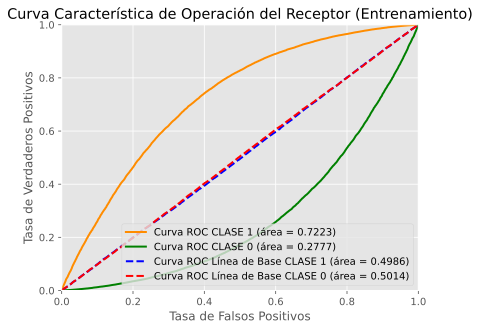

In [59]:
last_train_probabilities = train_epoch_probabilities[-1]
flat_last_train_probabilities = np.array([prob for sublist in last_train_probabilities for prob in sublist])

filtered_train_probabilities = flat_last_train_probabilities[valid_indices_train]

fpr_positivos, tpr_positivos, thresholds_positivos = roc_curve(filtered_train_labels, filtered_train_probabilities[:, 1])
roc_auc_positivos = auc(fpr_positivos, tpr_positivos)

fpr_negativos, tpr_negativos, thresholds_negativos = roc_curve(filtered_train_labels, filtered_train_probabilities[:, 0])
roc_auc_negativos = auc(fpr_negativos, tpr_negativos)

plt.figure()
plt.plot(fpr_positivos, tpr_positivos, color='darkorange', lw=2, label='Curva ROC CLASE 1 (área = %0.4f)' % roc_auc_positivos)
plt.plot(fpr_negativos, tpr_negativos, color='green', lw=2, label='Curva ROC CLASE 0 (área = %0.4f)' % roc_auc_negativos)
plt.plot(fpr_random_positivos, tpr_random_positivos, color='blue', lw=2, linestyle='--', label='Curva ROC Línea de Base CLASE 1 (área = %0.4f)' % roc_auc_random_positivos)
plt.plot(fpr_random_negativos, tpr_random_negativos, color='red', lw=2, linestyle='--', label='Curva ROC Línea de Base CLASE 0 (área = %0.4f)' % roc_auc_random_negativos)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva Característica de Operación del Receptor (Entrenamiento)')
plt.legend(loc="lower right")
plt.show()

# **Curva ROC aplicada a la última época evaluada**

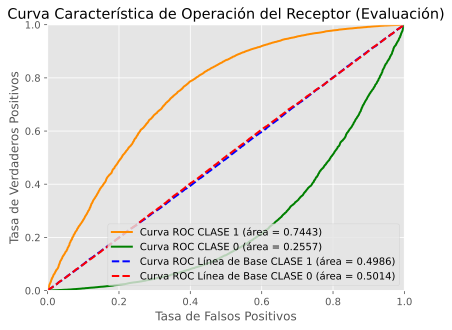

In [60]:
last_eval_labels = eval_epoch_labels[-1]
last_eval_probabilities = eval_epoch_probabilities[-1]

flat_last_eval_labels = np.array([label for sublist in last_eval_labels for label in sublist])
flat_last_eval_probabilities = np.array([prob for sublist in last_eval_probabilities for prob in sublist])

valid_indices_eval = np.where(flat_last_eval_labels != -1) # excluye etiquetas [PAD] == -1

filtered_eval_labels = flat_last_eval_labels[valid_indices_eval]
filtered_eval_probabilities = flat_last_eval_probabilities[valid_indices_eval]

fpr_positivos, tpr_positivos, _ = roc_curve(filtered_eval_labels, filtered_eval_probabilities[:, 1])
roc_auc_positivos = auc(fpr_positivos, tpr_positivos)

fpr_negativos, tpr_negativos, _ = roc_curve(filtered_eval_labels, filtered_eval_probabilities[:, 0])
roc_auc_negativos = auc(fpr_negativos, tpr_negativos)

plt.figure()
plt.plot(fpr_positivos, tpr_positivos, color='darkorange', lw=2, label='Curva ROC CLASE 1 (área = %0.4f)' % roc_auc_positivos)
plt.plot(fpr_negativos, tpr_negativos, color='green', lw=2, label='Curva ROC CLASE 0 (área = %0.4f)' % roc_auc_negativos)
plt.plot(fpr_random_positivos, tpr_random_positivos, color='blue', lw=2, linestyle='--', label='Curva ROC Línea de Base CLASE 1 (área = %0.4f)' % roc_auc_random_positivos)
plt.plot(fpr_random_negativos, tpr_random_negativos, color='red', lw=2, linestyle='--', label='Curva ROC Línea de Base CLASE 0 (área = %0.4f)' % roc_auc_random_negativos)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva Característica de Operación del Receptor (Evaluación)')
plt.legend(loc="lower right")
plt.show()

In [61]:
print("Tipo de datos de probabilidades:", type(filtered_train_probabilities[0]))
print("Tipo de datos de probabilidades:", type(random_probabilities[0]))
print("Primeras 5 probabilidades:", random_probabilities[:5])
print("Primeras 5 probabilidades:", filtered_train_probabilities[:5])

Tipo de datos de probabilidades: <class 'numpy.ndarray'>
Tipo de datos de probabilidades: <class 'numpy.ndarray'>
Primeras 5 probabilidades: [[0.07475315 0.92524685]
 [0.24935895 0.75064105]
 [0.46499945 0.53500055]
 [0.42669787 0.57330213]
 [0.04950915 0.95049085]]
Primeras 5 probabilidades: [[0.48588148 0.51411855]
 [0.35276628 0.64723366]
 [0.2626395  0.7373605 ]
 [0.3304364  0.6695636 ]
 [0.6845649  0.3154351 ]]
